## Topic modeling


### Getting text
In this sample, texts are three ebooks with different topics from Gutenburg:
1. Adrift in New York (children fiction)
2. Beethoven (music)
3. Sandwiches (cook)

In [1]:

# define a function to get .txt files in a folder
import codecs
from os import listdir
def list_textfiles(directory):
    "Return a list of filenames ending in '.txt' in DIRECTORY."
    textfiles = []
    for filename in listdir(directory):
        if filename.endswith(".txt"):
            textfiles.append(directory + "/" + filename)
    return textfiles   

# define a function to read the text in a .txt file

def read_txt(filename):
    try:
        f = codecs.open(filename,'r','utf-8') #open(filename,'r')
        text = f.read()
    finally:
        if f:
            f.close()
    return text

#import harry potter textfiles
filenames = list_textfiles('Plaintexts')
raw_texts = []
for n in filenames:
    raw_texts.append(read_txt(n))
print len(raw_texts)

3


### Preprocessing
- remove stopwords
- remove puctuation
- lemmatize

In [2]:

from nltk.corpus import stopwords 
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.tokenize import word_tokenize
import string


clean_texts = []
for text in raw_texts:
    # tokenize
    tok = " ".join(word_tokenize(text))
   
    #remove punctuation
    punctuation = set(string.punctuation) 
    re_punc = "".join(i for i in tok if i not in punctuation)
    
    #remove stopwords
    re_sw = " ".join([i for i in re_punc.lower().split() if i not in stopwords.words('english')])
    
    #lemmatization
    lemmatize = WordNetLemmatizer()
    le = " ".join(lemmatize.lemmatize(i) for i in re_sw.split())
    
    clean_texts.append(le)



In [3]:
#vectorize text

from sklearn.feature_extraction.text import CountVectorizer  
n_features = 1000
tf_vectorizer = CountVectorizer(min_df = 2,
                                strip_accents = 'unicode',
                                max_features=n_features,
                                stop_words='english')
tf = tf_vectorizer.fit_transform(clean_texts)

### LDA topic modeling

A simple exaple to explain LDA topic modeling:

Suppose you have the following set of sentences:

I like to eat broccoli and bananas.
I ate a banana and spinach smoothie for breakfast.
Chinchillas and kittens are cute.
My sister adopted a kitten yesterday.
Look at this cute hamster munching on a piece of broccoli.
What is latent Dirichlet allocation? It’s a way of automatically discovering topics that these sentences contain. For example, given these sentences and asked for 2 topics, LDA might produce something like

Sentences 1 and 2: 100% Topic A
Sentences 3 and 4: 100% Topic B
Sentence 5: 60% Topic A, 40% Topic B
Topic A: 30% broccoli, 15% bananas, 10% breakfast, 10% munching, … (at which point, you could interpret topic A to be about food)
Topic B: 20% chinchillas, 20% kittens, 20% cute, 15% hamster, … (at which point, you could interpret topic B to be about cute animals)

Reference: http://blog.echen.me/2011/08/22/introduction-to-latent-dirichlet-allocation/

In [4]:
from sklearn.decomposition import LatentDirichletAllocation

# set the topic counts
n_topic = 3

lda = LatentDirichletAllocation(n_components = n_topic, 
                                learning_method='online',
                                max_iter=50,
                                random_state=0)
doctopic = lda.fit(tf)

### Showing topics

In [7]:
def print_top_words(model, feature_names, n_top_words):
    
    #print top terms in each topic
    for topic_idx, topic in enumerate(model.components_):
        print "Topic #%d:" % topic_idx
        print " ".join([feature_names[i]
                        for i in topic.argsort()[:-n_top_words - 1:-1]])

# set the top n words in each topic
n_top_words=20
        
tf_feature_names = tf_vectorizer.get_feature_names()
print_top_words(lda, tf_feature_names, n_top_words)

Topic #0:
work time music year life man great master project friend art letter new good mind form way world thought best
Topic #1:
nt said mr know boy think man uncle yes like miss asked young work say time come make good sir
Topic #2:
bread cut add half project work salt make gutenbergtm chicken spread buttered cover press cold white book meat fish fine


#### From the three topics, we can see that
- topic 0: music related
- topic 1: children related
- topic 2: food related

### Visualizing topic models
#### Visualize topic distribution

In [8]:
# topic_distribution is a distribution of the topics in each text
topic_distribution = lda.transform(tf)

print topic_distribution # not normalized (sum of each row is not 1)

[[  2.78220006e-04   9.99694288e-01   2.74919906e-05]
 [  9.99641689e-01   3.31086127e-04   2.72251925e-05]
 [  7.62868577e-05   7.44416846e-05   9.99849271e-01]]


The list above is a probability of topic distrubition in the three texts.

Next we will try to visualize the topic distribution in a heatmap.

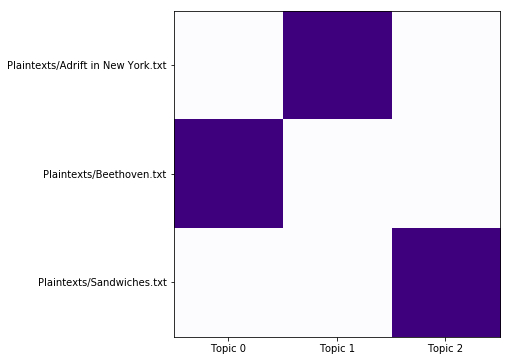

In [14]:
import matplotlib.ticker as ticker
import matplotlib.cm as cm
import matplotlib as mpl
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

flight_matrix = topic_distribution 

# set labels of Y axis as filenames
yLabel = list_textfiles('Plaintexts')#['Adrift in New York','Beethoven','Sandwiches']

# set labels of X axis as topic index
xLabel = range(n_topic)
# add "Topic " to each element (1,2,3) in xLabel
s = "Topic "
for i in xrange(len(xLabel)):
    xLabel[i] = s + str(xLabel[i])


fig = plt.figure()
fig, ax = plt.subplots(1,1, figsize=(6,6))


ax.set_xticks(np.arange(len(xLabel)))
ax.set_yticks(np.arange(len(yLabel)))

ax.set_xticklabels(xLabel)
ax.set_yticklabels(yLabel)

heatplot = ax.imshow(flight_matrix, cmap='Purples')


As we discovered above:
    
topic 0: music related
    
topic 1: children related
    
topic 2: food related

The distribution figure shows that the topics generated are correspondent with the content of the three texts.

#### Interactive visualization - pyLDAvis

In [11]:
import pyLDAvis
import pyLDAvis.sklearn
pyLDAvis.enable_notebook()
pyLDAvis.sklearn.prepare(lda, tf, tf_vectorizer)

/Users/zjm/anaconda/lib/python2.7/site-packages/pyLDAvis/_prepare.py:387: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  topic_term_dists = topic_term_dists.ix[topic_order]


PreparedData(topic_coordinates=            Freq  cluster  topics         x         y
topic                                                
0      43.144782        1       1 -0.070517 -0.100312
1      42.326522        1       2 -0.136012  0.081132
2      14.528696        1       3  0.206530  0.019180, topic_info=     Category        Freq         Term       Total  loglift  logprob
term                                                                
617   Default  544.000000           nt  544.000000  30.0000  30.0000
150   Default  195.000000        bread  195.000000  29.0000  29.0000
790   Default  500.000000         said  500.000000  28.0000  28.0000
234   Default  129.000000          cut  129.000000  27.0000  27.0000
72    Default  110.000000          add  110.000000  26.0000  26.0000
431   Default  136.000000         half  136.000000  25.0000  25.0000
597   Default  371.000000           mr  371.000000  24.0000  24.0000
598   Default  213.000000        music  213.000000  23.0000  23.0000
791   Default   74.000000         salt   74.000000  22.0000  22.0000
718   Default  265.000000      project  265.000000  21.0000  21.0000
996   Default  152.000000          yes  152.000000  20.0000  20.0000
986   Default  600.000000         work  600.000000  19.0000  19.0000
916   Default  166.000000        think  166.000000  18.0000  18.0000
586   Default  146.000000         miss  146.000000  17.0000  17.0000
181   Default   54.000000      chicken   54.000000  16.0000  16.0000
155   Default   51.000000     buttered   51.000000  15.0000  15.0000
855   Default   53.000000       spread   53.000000  14.0000  14.0000
149   Default  200.000000          boy  200.000000  13.0000  13.0000
232   Default   50.000000        cover   50.000000  12.0000  12.0000
566   Default  139.000000       master  139.000000  11.0000  11.0000
942   Default  170.000000        uncle  170.000000  10.0000  10.0000
705   Default   52.000000        press   52.000000   9.0000   9.0000
193   Default   57.000000         cold   57.000000   8.0000   8.0000
112   Default  150.000000        asked  150.000000   7.0000   7.0000
975   Default   50.000000        white   50.000000   6.0000   6.0000
428   Default  162.000000  gutenbergtm  162.000000   5.0000   5.0000
558   Default  204.000000         make  204.000000   4.0000   4.0000
502   Default  208.000000         know  208.000000   3.0000   3.0000
573   Default   40.000000         meat   40.000000   2.0000   2.0000
146   Default   57.000000         book   57.000000   1.0000   1.0000
...       ...         ...          ...         ...      ...      ...
634    Topic3   31.124946        olive   33.781345   1.8471  -5.0602
766    Topic3   28.323293       remove   30.973722   1.8396  -5.1545
705    Topic3   47.931764        press   52.558003   1.8369  -4.6284
169    Topic3   17.120649       center   18.785102   1.8363  -5.6579
866    Topic3   23.655310         stir   26.303985   1.8229  -5.3346
505    Topic3   13.387010           la   15.044272   1.8123  -5.9039
145    Topic3   13.390011      boiling   15.047838   1.8123  -5.9037
697    Topic3   29.253129        pound   32.887940   1.8119  -5.1222
857    Topic3   20.850736       square   23.497073   1.8096  -5.4608
167    Topic3   12.452950       caviar   14.110047   1.8041  -5.9763
968    Topic3   32.050243        water   36.666711   1.7945  -5.0309
927    Topic3   18.054915       tongue   20.697700   1.7924  -5.6048
975    Topic3   44.195196        white   50.770946   1.7903  -4.7096
905    Topic3   17.121836          tea   19.759004   1.7858  -5.6579
839    Topic3   16.189587       smooth   18.825648   1.7782  -5.7139
528    Topic3   20.856498        level   24.477564   1.7690  -5.4606
431    Topic3  101.142560         half  136.101985   1.6322  -3.8817
193    Topic3   45.127568         cold   57.568233   1.6856  -4.6887
814    Topic3   27.394638        serve   36.883117   1.6316  -5.1879
146    Topic3   38.598573         book   57.862097   1.5242  -4.8450
168    Topic3   27.391327     

#### Introducing pyLDAvis

[pyLDAvis](http://pyldavis.readthedocs.io/en/latest/modules/API.html) is designed to help users interpret the topics in a topic model that has been fit to a corpus of text data. The
package extracts information from a fitted LDA topic model to inform an interactive web-based visualization

It answers three questions:
What is the meaning of each topic?
How prevalent is each topic?
How do the topics relate to each other?

- the size of the circle represents the documents in each topic
- the bars in the left part show the most frequent keywords in each topic
- the distance among the circles shows the similarity of different topics
- set λ = 1, the words with high frequency are more relevant to the topic,
- set λ = 0, words more exclusive are more relavent to the topic.
